# 03 - Modelo Triplet Loss MFCC + deltas + delta2
*Monserrat Montero T.*

### ¿Qué cambios se aplicaron respecto a Modelo 02?
+ Cambio de un Modelo clasificador a uno Siamese para incluir el audio de estudio y poder abordar canciones nuevas en tests.
+ Aumento de datos obtenidos de cada clip de solo MFCC a MFCC + deltas + más ejemplos negativos par mejorar la robustez
+ Aumento de ventanas por clip. (Primero en testing pero finalmente en entrenamiento.)
+ Cambio a Triplet Loss/ Contrastive Loss para que el modelo aprenda relaciones relativas, no absolutas. Así tolerará variaciones.


* Representación Acústica: $MFCC$ + $delta$ + $delta^2$
* Triplet Loss: con tripletas generadas usando una ventana cercana al segundo etiquetado
* Evaluación basada en distancia entre embeddings

Esta versión del modelo tiene normalización por canción y Múltiples ventanas potivas alrededor del segundo correcto (+/- 2 segundos
)

🔍 Diagnóstico de lo que pudo pasar
1. Muchas ventanas positivas ≠ mejor señal
Al añadir ventanas positivas con un rango amplio (±2 segundos), aumentamos la variabilidad dentro de la clase positiva.

Aunque la idea era robustecer el aprendizaje, ahora el modelo recibe señales poco consistentes: aprende que el ancla se parece a muchas cosas, incluso si algunas de esas ventanas no son tan similares en la práctica.

Resultado: el modelo reduce artificialmente las distancias, perdiendo la capacidad de detectar un pico nítido de similitud.

2. Normalización por canción
La normalización por canción reduce el contraste global entre clips y canciones diferentes.

Esto puede ser útil si el modelo aprende bien las relaciones internas, pero si aún no ha logrado captar la forma básica de similitud, puede atenuar señales importantes.

3. Modelo sobreentrenado en 'parecidos difusos'
El entrenamiento con muchas ventanas positivas y negativas suaves puede llevar a un modelo que minimiza la pérdida siendo conservador, haciendo que todas las distancias converjan a valores medios.

##### Dataset

In [2]:
from pathlib import Path
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm

# --- Configuración general ---
sr_target = 48000
n_mfcc = 20
hop_length = 512
ventana = 93
salto = 46  # 50% superposición

# Dataset de etiquetas
ruta_excel = Path("etiquetado.xlsx")
df = pd.read_excel(ruta_excel)

def convertir_a_segundos(valor):
    if isinstance(valor, str) and ":" in valor:
        minutos, segundos = map(int, valor.split(":"))
        return minutos * 60 + segundos
    if isinstance(valor, (int, float)) and valor >= 0:
        return int(valor)
    return -1

df["segundo_label"] = df["segundo_inicio"].apply(convertir_a_segundos)

# Eliminar columnas específicas que no usaremos para entrenamiento
df = df.drop(columns=["Unnamed: 7", "Unnamed: 8", "Unnamed: 5", "Unnamed: 6"], errors="ignore")

df_validos = df[df["segundo_label"] >= 0].reset_index(drop=True)
df_validos


,audio_base,carpeta,archivo_clip,segundo_inicio,duracion_clip,segundo_label
0,bzrp_session_milo_j_bizarrap.mp3,clips_david,clip01.mp4,00:00,15,0
1,bzrp_session_milo_j_bizarrap.mp3,clips_david,clip02.mp4,00:15,15,15
2,bzrp_session_milo_j_bizarrap.mp3,clips_david,clip03.mp4,00:30,15,30
3,bzrp_session_milo_j_bizarrap.mp3,clips_david,clip04.mp4,00:45,15,45
4,bzrp_session_milo_j_bizarrap.mp3,clips_david,clip05.mp4,01:00,15,60
...,...,...,...,...,...,...
191,tu_me_dejaste_de_querer_c_tangana.mp3,clips_youtube,clip07.mp4,01:47,15,107
192,tu_me_dejaste_de_querer_c_tangana.mp3,clips_youtube,clip08.mp4,02:03,15,123
193,tu_me_dejaste_de_querer_c_tangana.mp3,clips_youtube,clip09.mp4,02:18,15,138
194,tu_me_dejaste_de_querer_c_tangana.mp3,clips_youtube,clip10.mp4,02:33,15,153


In [3]:
# --- Normalización por canción ---
def normalize_per_song(mfcc):
    mean = np.mean(mfcc, axis=1, keepdims=True)
    std = np.std(mfcc, axis=1, keepdims=True) + 1e-8
    return (mfcc - mean) / std

# --- Función para obtener MFCC stacked ---
def mfcc_stacked(audio):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr_target, n_mfcc=n_mfcc, hop_length=hop_length)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    stacked = np.vstack([mfcc, delta, delta2])
    return normalize_per_song(stacked)

# --- Función para obtener ventanas ---
def extraer_ventanas(matriz, salto_frames=salto):
    ventanas = []
    for i in range(0, matriz.shape[1] - ventana + 1, salto_frames):
        submat = matriz[:, i:i + ventana]
        if submat.shape[1] == ventana:
            ventanas.append(submat.mean(axis=1))
    return ventanas

# --- Tripletas finales ---
anchors = []
positives = []
negatives = []

for _, fila in tqdm(df_validos.iterrows(), total=len(df_validos)):
    base_audio = Path(fila["audio_base"]).stem
    carpeta = fila["carpeta"].strip().strip("/").strip("\\")
    clip_nombre = fila["archivo_clip"].replace(".mp4", ".wav")
    segundo_real = fila["segundo_label"]

    # Rutas
    ruta_clip = Path("clips_syntrack") / base_audio / carpeta / "wavs" / clip_nombre
    ruta_estudio = Path("clips_syntrack") / base_audio / "cancion_estudio" / f"{base_audio}.wav"

    if not ruta_clip.exists() or not ruta_estudio.exists():
        print(f"⚠️  Faltan archivos para: {ruta_clip} o {ruta_estudio}")
        continue

    # Cargar y procesar clip
    try:
        clip_audio, _ = librosa.load(ruta_clip, sr=sr_target)
        stacked_clip = mfcc_stacked(clip_audio)
        ventanas_clip = extraer_ventanas(stacked_clip)
        if len(ventanas_clip) == 0:
            continue
    except:
        continue

    # Cargar y procesar canción de estudio
    try:
        estudio_audio, _ = librosa.load(ruta_estudio, sr=sr_target)
        stacked_estudio = mfcc_stacked(estudio_audio)
    except:
        continue

    # --- Ventanas positivas (±2s del segundo real) ---
    offsets = [-2, -1, 0, 1, 2]
    positives_vectors = []
    for offset in offsets:
        pos_sec = segundo_real + offset
        frame_pos = int((pos_sec * sr_target) / hop_length)
        if 0 <= frame_pos <= stacked_estudio.shape[1] - ventana:
            vec = stacked_estudio[:, frame_pos:frame_pos + ventana].mean(axis=1)
            positives_vectors.append(vec)

    if len(positives_vectors) == 0:
        continue

    # --- Ventanas negativas ---
    segundos_totales = stacked_estudio.shape[1] * hop_length // sr_target
    segundos_negativos = [s for s in range(5, segundos_totales - 5) if abs(s - segundo_real) > 3]
    if len(segundos_negativos) < 2:
        continue
    segundos_negativos = np.random.choice(segundos_negativos, 2, replace=False)

    vec_negs = []
    for s_neg in segundos_negativos:
        f_neg = int((s_neg * sr_target) / hop_length)
        if f_neg + ventana <= stacked_estudio.shape[1]:
            vec_neg = stacked_estudio[:, f_neg:f_neg + ventana].mean(axis=1)
            vec_negs.append(vec_neg)

    if len(vec_negs) < 2:
        continue

    # --- Generar tripletas ---
    for v_anchor in ventanas_clip:
        for vec_pos in positives_vectors:
            anchors.append(v_anchor)
            positives.append(vec_pos)
            negatives.append(vec_negs[0])

            anchors.append(v_anchor)
            positives.append(vec_pos)
            negatives.append(vec_negs[1])

# Convertir a arrays finales
anchors = np.array(anchors)
positives = np.array(positives)
negatives = np.array(negatives)

print(f"✅ Dataset de tripletas generado: {anchors.shape}, {positives.shape}, {negatives.shape}")


100%|██████████| 196/196 [02:02<00:00,  1.59it/s]

✅ Dataset de tripletas generado: (59364, 60), (59364, 60), (59364, 60)


In [4]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# --- División entrenamiento / validación
A_train, A_val, P_train, P_val, N_train, N_val = train_test_split(
    anchors, positives, negatives, test_size=0.2, random_state=42
)

# --- Dataset de entrenamiento
train_ds = tf.data.Dataset.from_tensor_slices(((A_train, P_train, N_train), tf.zeros(len(A_train))))
train_ds = train_ds.shuffle(buffer_size=1024).batch(64).prefetch(tf.data.AUTOTUNE)

# --- Dataset de validación
val_ds = tf.data.Dataset.from_tensor_slices(((A_val, P_val, N_val), tf.zeros(len(A_val))))
val_ds = val_ds.batch(64).prefetch(tf.data.AUTOTUNE)

##### Modelo

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

# Dimensión de entrada (MFCC + delta + delta2)
input_dim = anchors.shape[1]

# --- Encoder compartido ---
def build_encoder():
    inp = Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu')(inp)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32)(x)  # No activación final
    return Model(inp, x, name="Encoder")

encoder = build_encoder()

# --- Inputs tripleta ---
anchor_input = Input(shape=(input_dim,))
positive_input = Input(shape=(input_dim,))
negative_input = Input(shape=(input_dim,))

# --- Pasar por encoder ---
encoded_anchor = encoder(anchor_input)
encoded_positive = encoder(positive_input)
encoded_negative = encoder(negative_input)

# --- Modelo final ---
triplet_model = Model(
    inputs=[anchor_input, positive_input, negative_input],
    outputs=[encoded_anchor, encoded_positive, encoded_negative]
)
triplet_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder             │ (None, 32)        │     18,144 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
│                     │                   │            │ input_layer_3[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,144 (70.88 KB)

 Trainable params: 18,144 (70.88 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# --- Función de pérdida personalizada ---
def triplet_loss_fn(margin=0.5):
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
        return tf.reduce_mean(tf.maximum(pos_dist - neg_dist + margin, 0.0))
    return loss


In [7]:
# Modificar la clase TripletModel
class TripletModel(tf.keras.Model):
    def __init__(self, encoder, margin=0.5):
        super().__init__()
        self.encoder = encoder
        self.margin = margin
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.val_loss_tracker = tf.keras.metrics.Mean(name="val_loss")

    def compile(self, optimizer, **kwargs):
        super().compile(optimizer=optimizer, **kwargs)

    def train_step(self, data):
        (anchor, positive, negative), _ = data

        with tf.GradientTape() as tape:
            emb_anchor = self.encoder(anchor, training=True)
            emb_positive = self.encoder(positive, training=True)
            emb_negative = self.encoder(negative, training=True)

            # Calcular triplet loss
            pos_dist = tf.reduce_sum(tf.square(emb_anchor - emb_positive), axis=1)
            neg_dist = tf.reduce_sum(tf.square(emb_anchor - emb_negative), axis=1)
            loss = tf.reduce_mean(tf.maximum(pos_dist - neg_dist + self.margin, 0.0))

        grads = tape.gradient(loss, self.encoder.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.encoder.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        (anchor, positive, negative), _ = data
        
        emb_anchor = self.encoder(anchor, training=False)
        emb_positive = self.encoder(positive, training=False)
        emb_negative = self.encoder(negative, training=False)

        # Calcular triplet loss para validación
        pos_dist = tf.reduce_sum(tf.square(emb_anchor - emb_positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(emb_anchor - emb_negative), axis=1)
        loss = tf.reduce_mean(tf.maximum(pos_dist - neg_dist + self.margin, 0.0))
        
        self.val_loss_tracker.update_state(loss)
        return {"loss": self.val_loss_tracker.result()}

    def call(self, inputs):
        anchor, positive, negative = inputs
        emb_a = self.encoder(anchor)
        emb_p = self.encoder(positive)
        emb_n = self.encoder(negative)
        return emb_a, emb_p, emb_n

    @property
    def metrics(self):
        return [self.loss_tracker, self.val_loss_tracker]


##### Entrenamiento

In [8]:

# Compilar y entrenar
final_model = TripletModel(encoder)
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

history = final_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20


743/743 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.2906 - val_loss: 0.0650
Epoch 2/20
743/743 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0491 - val_loss: 0.0331
Epoch 3/20
743/743 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0257 - val_loss: 0.0265
Epoch 4/20
743/743 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0190 - val_loss: 0.0234
Epoch 5/20
743/743 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0158 - val_loss: 0.0233
Epoch 6/20
743/743 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0130 - val_loss: 0.0193
Epoch 7/20
743/743 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0103 - val_loss: 0.0174
Epoch 8/20
743/743 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - val_loss: 0.0186
Epoch 9/20
743/743 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0098 - val_loss: 0.0154
Epoch 10/20
743/743 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0083 - val_loss: 0.0194
Epoch 11/20
743/743 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0076 - val_loss: 0.0168
Epoch 12/20
743/743 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.

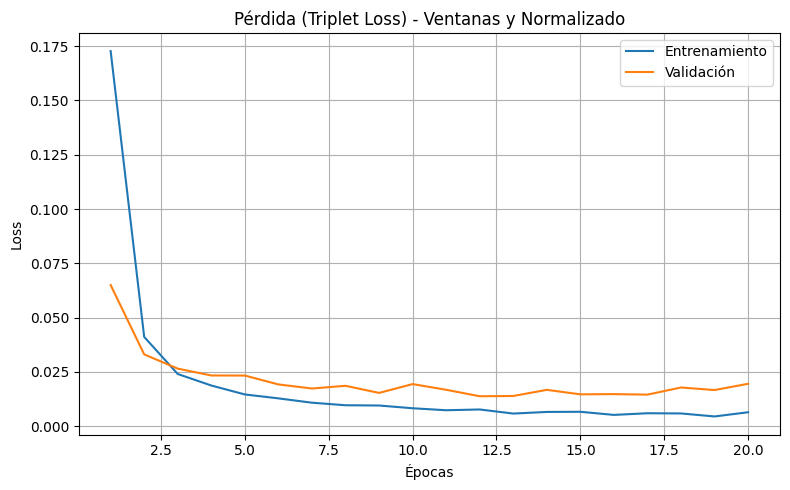

In [15]:
import matplotlib.pyplot as plt

# --- Extraer pérdidas desde el historial ---
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(train_loss) + 1)

# --- Graficar ---
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label="Entrenamiento")
plt.plot(epochs, val_loss, label="Validación")
plt.title("Pérdida (Triplet Loss) - Ventanas y Normalizado")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



##### Testing

🔍 Resultados de la comparación:
cancion : yellow_coldplay, clip: clip03.wav, carpeta: clips_youtube
🎯 Top 5 predicciones de segundo más similares:
1. Segundo ~223 con distancia promedio 1.3336
2. Segundo ~245 con distancia promedio 1.3337
3. Segundo ~38 con distancia promedio 1.3422
4. Segundo ~230 con distancia promedio 1.3520
5. Segundo ~239 con distancia promedio 1.3529


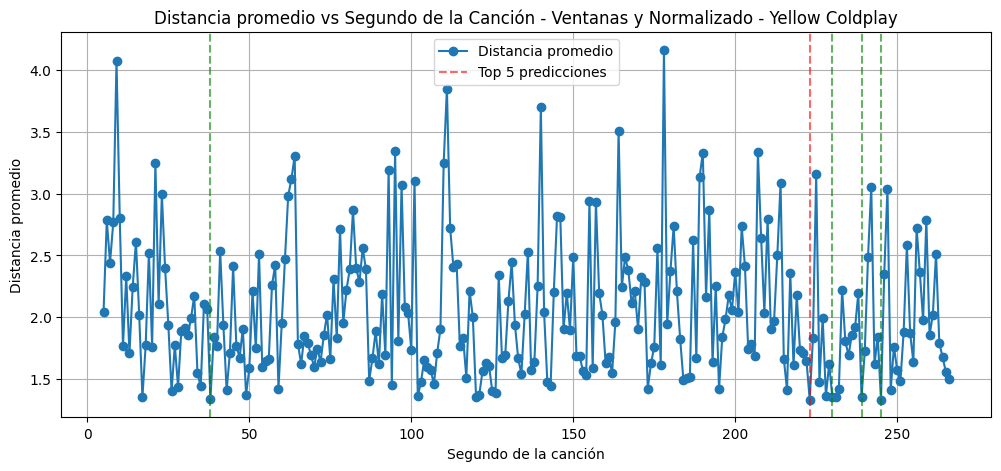

In [17]:
from pathlib import Path
import librosa
import numpy as np
from tqdm import tqdm

# ---------------------
# 🔧 Parámetros del clip
# ---------------------
nombre_cancion = "yellow_coldplay" # Cambia según la canción que quieras probar
nombre_clip = "clip03.wav"          # Cambia según el clip que quieras probar
carpeta = "clips_youtube"           # Carpeta donde están los clips

# Rutas
ruta_clip = Path("clips_syntrack") / nombre_cancion / carpeta / "wavs" / nombre_clip
ruta_estudio = Path("clips_syntrack") / nombre_cancion / "cancion_estudio" / f"{nombre_cancion}.wav"

# --- MFCC utils ---
def normalize_per_song(mfcc):
    mean = np.mean(mfcc, axis=1, keepdims=True)
    std = np.std(mfcc, axis=1, keepdims=True) + 1e-8
    return (mfcc - mean) / std

def mfcc_stacked(audio):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr_target, n_mfcc=n_mfcc, hop_length=hop_length)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    stacked = np.vstack([mfcc, delta, delta2])
    return normalize_per_song(stacked)

def extraer_ventanas(matriz, salto_frames=salto):
    ventanas = []
    for i in range(0, matriz.shape[1] - ventana + 1, salto_frames):
        submat = matriz[:, i:i + ventana]
        if submat.shape[1] == ventana:
            ventanas.append(submat.mean(axis=1))
    return np.array(ventanas)

# --- Cargar y procesar clip ---
clip_audio, _ = librosa.load(ruta_clip, sr=sr_target)
stacked_clip = mfcc_stacked(clip_audio)
ventanas_clip = extraer_ventanas(stacked_clip)

# --- Cargar y procesar canción de estudio ---
estudio_audio, _ = librosa.load(ruta_estudio, sr=sr_target)
stacked_estudio = mfcc_stacked(estudio_audio)

# --- Obtener vectores de cada segundo (saltando por segundo completo) ---
vectores_estudio = []
segundos = []

total_segundos = (stacked_estudio.shape[1] * hop_length) // sr_target
for s in range(5, total_segundos - 5):
    frame_inicio = int((s * sr_target) / hop_length)
    if frame_inicio + ventana > stacked_estudio.shape[1]:
        continue
    vec = stacked_estudio[:, frame_inicio:frame_inicio + ventana].mean(axis=1)
    vectores_estudio.append(vec)
    segundos.append(s)

vectores_estudio = np.array(vectores_estudio)

# --- Codificar clip y canción ---
embeddings_clip = encoder.predict(ventanas_clip, verbose=0)
embeddings_estudio = encoder.predict(vectores_estudio, verbose=0)

# --- Comparar cada segundo con todas las ventanas del clip ---
distancias = []
for emb_estudio in embeddings_estudio:
    dists = np.linalg.norm(embeddings_clip - emb_estudio, axis=1)
    distancias.append(np.mean(dists))

# --- Top 5 segundos más similares ---
top5_indices = np.argsort(distancias)[:5]
top5_segundos = [segundos[i] for i in top5_indices]
top5_distancias = [distancias[i] for i in top5_indices]

print("🔍 Resultados de la comparación:")
print(f"cancion : {nombre_cancion}, clip: {nombre_clip}, carpeta: {carpeta}")
print("🎯 Top 5 predicciones de segundo más similares:")
for i, (seg, dist) in enumerate(zip(top5_segundos, top5_distancias), 1):
    print(f"{i}. Segundo ~{seg} con distancia promedio {dist:.4f}")


# --- Plot actualizado con top 5 ---
plt.figure(figsize=(12, 5))
plt.plot(segundos, distancias, marker='o', label="Distancia promedio")
#plt.title("Distancia promedio entre ventanas del clip y cada segundo de la canción")
plt.title("Distancia promedio vs Segundo de la Canción - Ventanas y Normalizado - Yellow Coldplay")
plt.xlabel("Segundo de la canción")
plt.ylabel("Distancia promedio")
plt.grid(True)

iaa = 1
coloraaa = 'red'
for seg in top5_segundos:
    plt.axvline(seg, color=coloraaa, linestyle='--', alpha=0.6)
    if iaa == 1: coloraaa = 'green'; iaa = 0
plt.legend(["Distancia promedio", "Top 5 predicciones"])
plt.show()

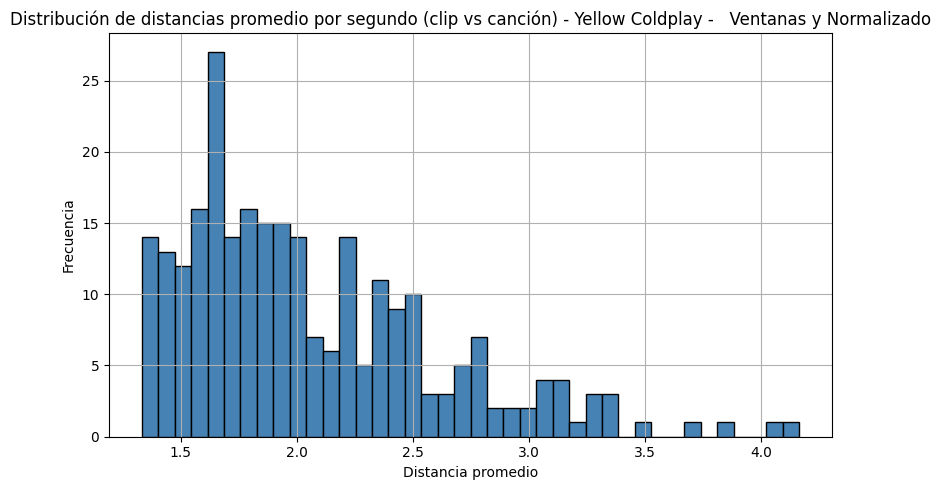

In [14]:
# --- Histograma de distancias --- 
plt.figure(figsize=(8, 5))
plt.hist(distancias, bins=40, color="steelblue", edgecolor="black")
plt.title("Distribución de distancias promedio por segundo (clip vs canción) - Yellow Coldplay -   Ventanas y Normalizado")
plt.xlabel("Distancia promedio")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()